# Large-scale variational sparse GP
_Author: Mathis Hardion_

In [1]:
# Imports
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP, ExactGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
rng = torch.manual_seed(0)

In [2]:
# Helpers
def standardize(X_train, X_test, y_train, y_test):
    if type(X_train) == torch.Tensor:
        sqrt = torch.sqrt
    else:
        sqrt = np.sqrt
    X_mean, X_std = X_train.mean(0), sqrt(X_train.var(0))
    y_mean, y_std = y_train.mean(), sqrt(y_train.var())
    y_train -= y_mean
    y_test -= y_mean
    return ((X_train - X_mean[None,:])/X_std[None,:],
            (X_test - X_mean[None,:])/X_std[None,:],
            (y_train - y_mean)/y_std,
            (y_test - y_mean)/y_std)

def SMSE(y_pred, y_test):
    return (((y_test-y_pred)**2).mean()/y_test.var()).item()

def to_tensors(*arrays, **kwargs):
    return [torch.tensor(a, **kwargs) for a in arrays]

def test_sklearn_estimators(X_train, X_test, y_train, y_test, estimators):
    results = pd.DataFrame(index=["SMSE"])
    for est in estimators:
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        results[type(est).__name__] = SMSE(y_pred, y_test)
    return results

## Sarcos_inv dataset

In [3]:
sarcos_train = loadmat('data/sarcos_inv.mat')['sarcos_inv']
X_train, y_train = sarcos_train[:, :21], sarcos_train[:,21]
sarcos_test = loadmat('data/sarcos_inv_test.mat')['sarcos_inv_test']
X_test, y_test = sarcos_test[:, :21], sarcos_test[:,21]

In [4]:
X_train, X_test, y_train, y_test = standardize(X_train, X_test, y_train, y_test)

In [5]:
estimators = [linear_model.LinearRegression(), ensemble.HistGradientBoostingRegressor()]
results = test_sklearn_estimators(X_train, X_test, y_train, y_test, estimators)
results

,LinearRegression,HistGradientBoostingRegressor
SMSE,0.075054,0.025795


In [6]:
X_train, X_test, y_train, y_test = to_tensors(X_train, X_test, y_train, y_test, device=device)

In [7]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [8]:
# SGP
class VARSGP(ExactGP):
    def __init__(self, train_x, train_y, n_inducing, likelihood=None):
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(VARSGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.InducingPointKernel(self.base_covar_module, inducing_points=train_x[:n_inducing, :], likelihood=likelihood)
        self.register_added_loss_term('titsias_term')

    def to(self, device):
        if device.type == 'cuda':
            return self.cuda()
        return self

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        self.update_added_loss_term("titsias_term", gpytorch.mlls.InducingPointKernelAddedLossTerm(gpytorch.distributions.MultivariateNormal(0*mean_x, self.base_covar_module(x)), gpytorch.distributions.MultivariateNormal(0*mean_x, covar_x), self.likelihood))
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def fit(self, n_iter=500, optimizer=torch.optim.Adam, plot=True, print_every=10, **kwargs):
        self.train()
        opt = optimizer(self.parameters(), **kwargs)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        if plot:
            losses = []
        for i in range(n_iter):
            opt.zero_grad()
            loss = -mll(model(X_train), y_train)
            loss.backward()
            opt.step()
            if plot:
                losses.append(loss.item())
            if print_every and not ((i+1)%print_every):
                print(f"Iteration {i+1}/{n_iter} - loss = {loss.item()}")
        if plot:
            plt.plot(losses)
            plt.title("Negative MLL over iterations")
            plt.show()

    def predict(self, X_test):
        model.eval()
        with torch.no_grad():
            return self.likelihood(model(X_test)).mean

Iteration 10/500 - loss = 2.519809823575926
Iteration 20/500 - loss = 2.309392849368191
Iteration 30/500 - loss = 2.143176110149478
Iteration 40/500 - loss = 2.013079964520631
Iteration 50/500 - loss = 1.9111545954347071
Iteration 60/500 - loss = 1.82839227521425
Iteration 70/500 - loss = 1.7586615160935377
Iteration 80/500 - loss = 1.6934787029623224
Iteration 90/500 - loss = 1.629235581630492
Iteration 100/500 - loss = 1.566271076156969
Iteration 110/500 - loss = 1.5066524522184752
Iteration 120/500 - loss = 1.4497046339834845
Iteration 130/500 - loss = 1.3932887710050945
Iteration 140/500 - loss = 1.3380717214284343
Iteration 150/500 - loss = 1.2878341896453869
Iteration 160/500 - loss = 1.2436269447314134
Iteration 170/500 - loss = 1.2043488293900904
Iteration 180/500 - loss = 1.169092776752762
Iteration 190/500 - loss = 1.1373148498037347
Iteration 200/500 - loss = 1.1069740117811524
Iteration 210/500 - loss = 1.0781498271444583
Iteration 220/500 - loss = 1.0497438565636885
Iterat

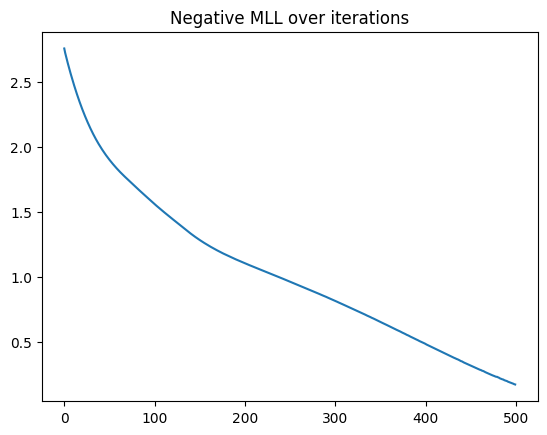

In [9]:
model = VARSGP(X_train, y_train, 50).to(device)
model.fit(lr=.01)

In [10]:
y_pred = model.predict(X_test)
results['SGP'] = SMSE(y_pred, y_test)
results

,LinearRegression,HistGradientBoostingRegressor,SGP
SMSE,0.075054,0.025795,0.033671


## Abalone dataset

In [11]:
# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features.iloc[:,1:].to_numpy()
y = abalone.data.targets.to_numpy().flatten().astype(float)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test, y_train, y_test = standardize(X_train, X_test, y_train, y_test)

In [13]:
estimators = [linear_model.LinearRegression(), ensemble.HistGradientBoostingRegressor(max_iter=1000)]
results = test_sklearn_estimators(X_train, X_test, y_train, y_test, estimators)
results

,LinearRegression,HistGradientBoostingRegressor
SMSE,0.477802,0.574448


Iteration 10/500 - loss = 1.5712848131323671
Iteration 20/500 - loss = 1.423632032061289
Iteration 30/500 - loss = 1.3373543427688779
Iteration 40/500 - loss = 1.2849768831624402
Iteration 50/500 - loss = 1.2485078496928617
Iteration 60/500 - loss = 1.2207728074639963
Iteration 70/500 - loss = 1.1972185373658255
Iteration 80/500 - loss = 1.1768224735185484
Iteration 90/500 - loss = 1.1603414651544521
Iteration 100/500 - loss = 1.1430605059635626
Iteration 110/500 - loss = 1.1288601678593597
Iteration 120/500 - loss = 1.1168074822682186
Iteration 130/500 - loss = 1.107764307293746
Iteration 140/500 - loss = 1.0977513378959833
Iteration 150/500 - loss = 1.0904804410073916
Iteration 160/500 - loss = 1.0838406043965734
Iteration 170/500 - loss = 1.078624385064881
Iteration 180/500 - loss = 1.073815189988982
Iteration 190/500 - loss = 1.0698554686797517
Iteration 200/500 - loss = 1.066431851624435
Iteration 210/500 - loss = 1.0634252783172244
Iteration 220/500 - loss = 1.0603778685575764
It

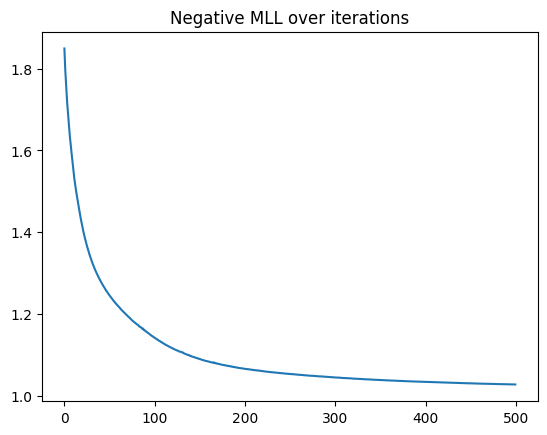

In [14]:
X_train, X_test, y_train, y_test = to_tensors(X_train, X_test, y_train, y_test, device=device)
model = VARSGP(X_train, y_train, 50).to(device)
model.fit(lr=.01)

In [15]:
y_pred = model.predict(X_test)
results['SGP'] = SMSE(y_pred, y_test)
results

,LinearRegression,HistGradientBoostingRegressor,SGP
SMSE,0.477802,0.574448,0.435678


## Forest Fires dataset

In [16]:
# fetch dataset
fires = fetch_ucirepo(id=162)

# data (as pandas dataframes)
X = fires.data.features
y = fires.data.targets
X = X.drop(["month", "day"], axis=1).to_numpy()
y = y.to_numpy().flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test, y_train, y_test = standardize(X_train, X_test, y_train, y_test)

In [17]:
estimators = [linear_model.LinearRegression(), ensemble.HistGradientBoostingRegressor(max_iter=1000)]
results = test_sklearn_estimators(X_train, X_test, y_train, y_test, estimators)
results

,LinearRegression,HistGradientBoostingRegressor
SMSE,0.998692,1.248558


Iteration 10/500 - loss = 1.8392367514021613
Iteration 20/500 - loss = 1.7320819766477848
Iteration 30/500 - loss = 1.6571863277338321
Iteration 40/500 - loss = 1.603179787996412
Iteration 50/500 - loss = 1.5619007759159032
Iteration 60/500 - loss = 1.529862288961414
Iteration 70/500 - loss = 1.5043076064058576
Iteration 80/500 - loss = 1.4837722430498717
Iteration 90/500 - loss = 1.467414763216231
Iteration 100/500 - loss = 1.4539297194168013
Iteration 110/500 - loss = 1.44241663311104
Iteration 120/500 - loss = 1.4322931813158488
Iteration 130/500 - loss = 1.423254029585883
Iteration 140/500 - loss = 1.415275238174923
Iteration 150/500 - loss = 1.408155212955855
Iteration 160/500 - loss = 1.4016308599516314
Iteration 170/500 - loss = 1.3957777197099603
Iteration 180/500 - loss = 1.3907408754221657
Iteration 190/500 - loss = 1.3864347456269939
Iteration 200/500 - loss = 1.3826754227186673
Iteration 210/500 - loss = 1.3792785835133419
Iteration 220/500 - loss = 1.3761439029430007
Itera

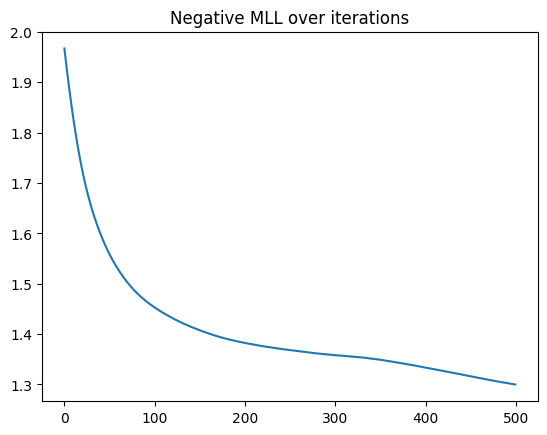

In [18]:
X_train, X_test, y_train, y_test = to_tensors(X_train, X_test, y_train, y_test, device=device)
model = VARSGP(X_train, y_train, 100).to(device)
model.fit(lr=.01)

In [19]:
y_pred = model.predict(X_test)
results['SGP'] = SMSE(y_pred, y_test)
results

,LinearRegression,HistGradientBoostingRegressor,SGP
SMSE,0.998692,1.248558,1.00942


## Electrical Grid Stability Simulated Data

In [20]:
# fetch dataset
elec = fetch_ucirepo(id=471)

# data (as pandas dataframes)
X = elec.data.features
y = elec.data.targets
X = X.to_numpy()
y = y['stab'].to_numpy().flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test, y_train, y_test = standardize(X_train, X_test, y_train, y_test)
estimators = [linear_model.LinearRegression(), ensemble.HistGradientBoostingRegressor(max_iter=1000)]
results = test_sklearn_estimators(X_train, X_test, y_train, y_test, estimators)

Iteration 100/1000 - loss = 1.385825628711877
Iteration 200/1000 - loss = 1.0486650731293312
Iteration 300/1000 - loss = 0.7597358045344857
Iteration 400/1000 - loss = 0.5068397747658615
Iteration 500/1000 - loss = 0.3952801597304303
Iteration 600/1000 - loss = 0.37636423100728134
Iteration 700/1000 - loss = 0.37187016107421783
Iteration 800/1000 - loss = 0.3688452446241849
Iteration 900/1000 - loss = 0.3659652732954219
Iteration 1000/1000 - loss = 0.36639449574956345


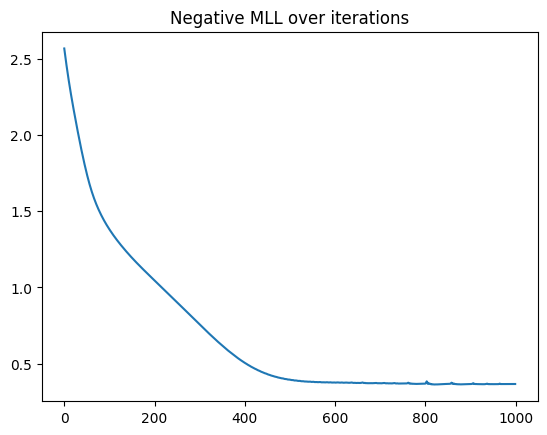

In [21]:
X_train, X_test, y_train, y_test = to_tensors(X_train, X_test, y_train, y_test, device=device)
model = VARSGP(X_train, y_train, 100).to(device)
model.fit(lr=.01, n_iter=1000, print_every=100)

In [22]:
y_pred = model.predict(X_test)
results['SGP'] = SMSE(y_pred, y_test)
results

,LinearRegression,HistGradientBoostingRegressor,SGP
SMSE,0.358792,0.04488,0.062721


## Stochastic vargp

In [ ]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # TODO: add InducingPointKernelAddedLossTerm

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = X_train[:500, :]
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))
losses = []
n_epochs = 15
for n in range(n_epochs):
    for x_batch, y_batch in iter(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

model.eval()
likelihood.eval()
with torch.no_grad():
    y_pred = likelihood(model(X_test)).mean
print('Stochastic variational GP SMSE:', (((y_test-y_pred)**2).mean()/y_test.var()).item())
plt.plot(losses)

## Cifar10 image reconstruction

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 71912020.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
cifar10_trainloader = DataLoader(cifar10_train, batch_size=1024, shuffle=True)

In [ ]:
def rgb2gray(u):
    return 0.2989 * u[:,0] + 0.5870 * u[:,1] + 0.1140 * u[:,2]

In [ ]:
X_train = None
y_train = None
for xb, yb in cifar10_trainloader:
    y_ = rgb2gray(xb)
    discard = torch.rand(y_.size()) < .5
    if X_train is None:
        y_train = y_.clone()
        X_train = y_.clone()
        X_train[discard] = 0
    else:
        y_train = torch.cat((y_train, y_), axis=0)
        x_ = y_.clone()
        x_[discard] = 0
        X_train = torch.cat((X_train, x_), axis=0)

In [ ]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=5, shuffle=True)

In [ ]:
class GPModelImg(ApproximateGP):
    def __init__(self, inducing_points):
        t = inducing_points.size(1)
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModelImg, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=t
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=t, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [ ]:
inducing_points = X_train[:50, :]
model = GPModelImg(inducing_points=inducing_points.flatten(1))
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(32*32)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.005)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))
losses = []
n_epochs = 50
for n in range(n_epochs):
    for x_batch, y_batch in iter(train_loader):
        optimizer.zero_grad()
        print(x_batch.size())
        output = model(x_batch.flatten(1))
        loss = -mll(output, y_batch.flatten(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
plt.plot(losses)

torch.Size([5, 32, 32])


RuntimeError: The size of tensor a (56270) must match the size of tensor b (974) at non-singleton dimension 1

In [ ]:
X_train.size()

torch.Size([50000, 32, 32])